In [6]:
import pandas as pd
from ProjectTools import OpenBeds
from ProjectTools.OpenBeds import filterDepth
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from scipy import stats
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn import preprocessing
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import pyranges as pr
import subprocess


In [2]:
dry = False

if dry == True:
    wgbs_bed_path = './test_data/mm39_ENCSR893RHD_modifications_mergeDups_sub.bed'
    tab_bed_path = './test_data/CRR008807_TAB_merged.bedGraph.gz.bismark.zero.cov_sub.bed'
    oxbs_bed_path = './test_data/CRD018546.gz_val_1_bismark_bt2_pe.deduplicated.bedGraph.gz.bismark.zero.cov_sub.bed'

    nano_2mod_path = './test_data/prom_R10.4.1_E8.2_WGS_brain_DH_5mC_nonAggregated_sub.bedMethyl'
    nano_3mod_path = './test_data/prom_R10.4.1_E8.2_WGS_brain_0.9.1_mods_sub.bed'
    
    nano_mc_df, nano_hmc_df = map(filterDepth, OpenBeds.get_nanopore_threeMod_wStrand(nano_3mod_path))

    nano_2mod_df = filterDepth(OpenBeds.get_nanopore_twoMod(nano_2mod_path))
    wgbs_df = filterDepth(OpenBeds.get_wgbs(wgbs_bed_path))
    tab_df = filterDepth(OpenBeds.get_bismark(tab_bed_path, "5hmC"))
    oxbs_df = filterDepth(OpenBeds.get_bismark(oxbs_bed_path, "5mC"))

else:
    wgbs_bed_path = './data/mm39_ENCSR893RHD_merged.bed'
    tab_bed_path = './data/TAB_data/CRR008807_TAB_merged.bedGraph.gz.bismark.zero.cov'
    oxbs_bed_path = './data/CRR008808_oxBS_remergedRaw.zero.cov_modified.bed'

    nano_2mod_path = './data/prom_R10.4.1_E8.2_WGS_brain_DH_5mC_nonAggregated.bedMethyl'
    nano_3mod_path = './data/prom_R10.4.1_E8.2_WGS_brain_0.9.1_mods.bed'

    nano_mc_df, nano_hmc_df = map(filterDepth, OpenBeds.get_nanopore_threeMod_wStrand(nano_3mod_path))

    nano_2mod_df = filterDepth(OpenBeds.get_nanopore_twoMod(nano_2mod_path))
    wgbs_df = filterDepth(OpenBeds.get_wgbs(wgbs_bed_path))
    tab_df = filterDepth(OpenBeds.get_bismark(tab_bed_path, "5hmC"))
    oxbs_df = filterDepth(OpenBeds.get_bismark(oxbs_bed_path, "5mC"))

In [3]:
def mergeMethods(bis_df, nano_df):
    bis_df, nano_df = map(lambda df: df.drop(columns=["method", "readCount", "modification_type"]), [bis_df, nano_df])
    wide_merged = pd.merge(
        bis_df, nano_df, "inner", ["chromosome", "chromStart", "chromEnd"], suffixes=["_Bisulphite", "_Nanopore"]
        )
    long_merged = pd.wide_to_long(wide_merged, stubnames=["readCount", "percentMeth"], i=["chromosome", "chromStart", "chromEnd"], 
                                  j="method", sep="_", suffix="\D+")
    return wide_merged.reset_index(drop=True), long_merged.reset_index()

def calcPearson(wide_df):
    x, y = wide_df["percentMeth_Bisulphite"], wide_df["percentMeth_Nanopore"]
    return stats.pearsonr(x, y)

def calcKS(wide_df):
    x, y = wide_df["percentMeth_Bisulphite"], wide_df["percentMeth_Nanopore"]
    return stats.ks_2samp(x, y, method="asymp")

In [4]:
two_mod_wide, two_mod_long = mergeMethods(wgbs_df, nano_2mod_df)
mc_df_wide, mc_df_long  = mergeMethods(oxbs_df, nano_mc_df)
hmc_df_wide, hmc_df_long = mergeMethods(tab_df, nano_hmc_df)

/mnt/data1/doh28/tools/condas/GeneralAnalysis/lib/python3.9/site-packages/seaborn/utils.py:482: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  new_legend = legend_func(handles, labels, loc=loc, **props)
/mnt/data1/doh28/tools/condas/GeneralAnalysis/lib/python3.9/site-packages/seaborn/utils.py:482: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  new_legend = legend_func(handles, labels, loc=loc, **props)
/mnt/data1/doh28/tools/condas/GeneralAnalysis/lib/python3.9/site-packages/seaborn/utils.py:482: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  new_legend = legend_func(handles, labels, loc=loc, **props)


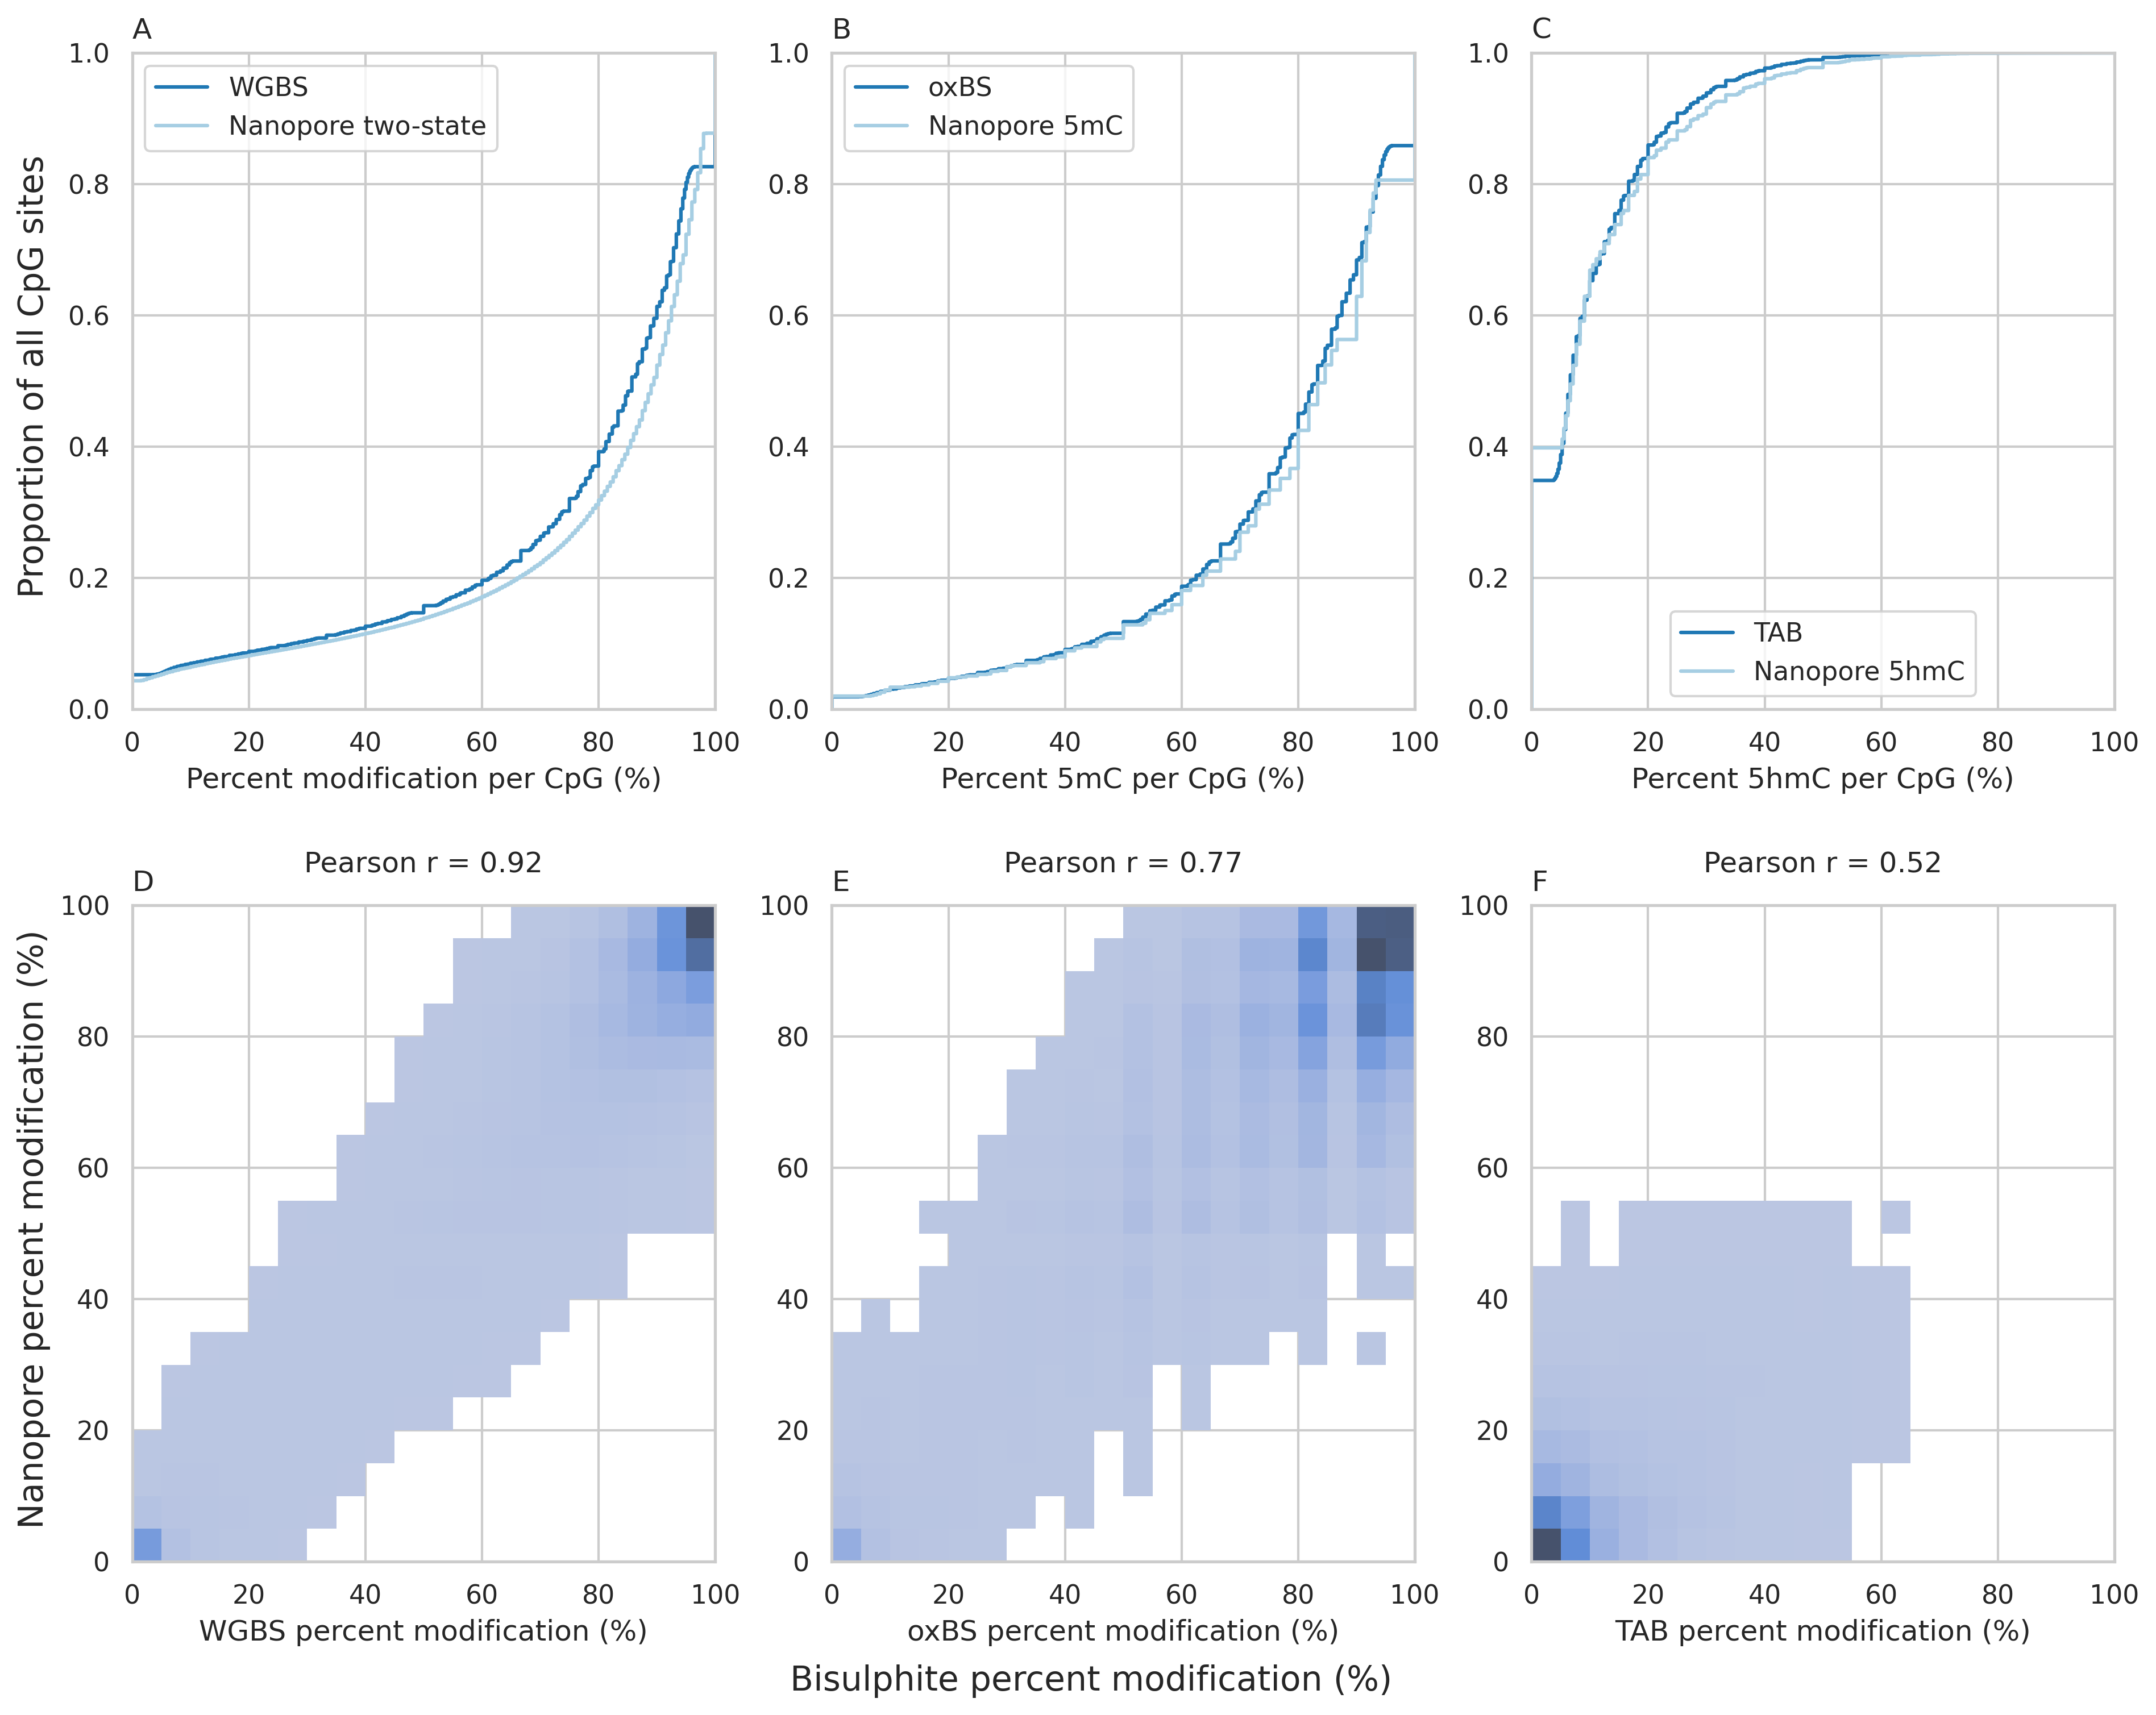

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

sns.set_theme(style="whitegrid")

fig1 = plt.figure(dpi=300, figsize=(15, 10)) 
gs1 = GridSpec(2, 1, fig1)

fig11 = fig1.add_subfigure(gs1[0, :])
gs11 = GridSpec(1, 3, fig11)
fig11.supylabel("Proportion of all CpG sites", x=0.08)

ax11 = fig11.add_subplot(gs11[0, 0])
ax12 = fig11.add_subplot(gs11[0, 1])
ax13 = fig11.add_subplot(gs11[0, 2])

sns.ecdfplot(two_mod_long, x="percentMeth", hue="method", palette="Paired", ax=ax11)
sns.move_legend(ax11, "upper left", title=None, labels=["WGBS", "Nanopore two-state"])
# ax11.text(50, 1.05, "Kolmogorov-Smirnov = {ks:.2f}".format(ks=calcKS(two_mod_wide)[0]), ha="center")
ax11.set_ylabel(None)
ax11.set_xlabel("Percent modification per CpG (%)")
ax11.set_title("A", loc="left")
ax11.set_xlim([0, 100])

sns.ecdfplot(mc_df_long, x="percentMeth", hue="method", palette="Paired", ax=ax12)
sns.move_legend(ax12, "upper left", title=None, labels=["oxBS", "Nanopore 5mC"])
# ax12.text(50, 1.05, "Kolmogorov-Smirnov = {ks:.2f}".format(ks=calcKS(mc_df_wide)[0]), ha="center")
ax12.set_ylabel(None)
ax12.set_xlabel("Percent 5mC per CpG (%)")
ax12.set_title("B", loc="left")
ax12.set_xlim([0, 100])

sns.ecdfplot(hmc_df_long, x="percentMeth", hue="method", palette="Paired", ax=ax13)
sns.move_legend(ax13, "lower center", title=None, labels=["TAB", "Nanopore 5hmC"])
# ax13.text(50, 1.05, "Kolmogorov-Smirnov = {ks:.2f}".format(ks=calcKS(hmc_df_wide)[0]), ha="center")
ax13.set_ylabel(None)
ax13.set_xlabel("Percent 5hmC per CpG (%)")
ax13.set_xlim([0, 100])
ax13.set_title("C", loc="left")

fig12 = fig1.add_subfigure(gs1[1, :])
fig12.supxlabel("Bisulphite percent modification (%)", y=-0.05)
fig12.supylabel("Nanopore percent modification (%)", x=0.08)
gs12 = GridSpec(1, 3, fig12)

ax14 = fig12.add_subplot(gs12[0, 0])
ax15 = fig12.add_subplot(gs12[0, 1])
ax16 = fig12.add_subplot(gs12[0, 2])

sns.histplot(two_mod_wide, x="percentMeth_Bisulphite", y="percentMeth_Nanopore", bins=20, pthresh=0.01, stat="density", ax=ax14)
ax14.text(50, 105, "Pearson r = {r:.2f}".format(r=calcPearson(two_mod_wide)[0]), ha="center")
ax14.set_xlim((0, 100))
ax14.set_ylim((0, 100))
ax14.set_xlabel("WGBS percent modification (%)")
ax14.set_ylabel(None)
ax14.set_title("D", loc="left")

sns.histplot(mc_df_wide, x="percentMeth_Bisulphite", y="percentMeth_Nanopore", bins=20, pthresh=0.01, stat="density", ax=ax15)
ax15.text(50, 105, "Pearson r = {r:.2f}".format(r=calcPearson(mc_df_wide)[0]), ha="center")
ax15.set_xlim((0, 100))
ax15.set_ylim((0, 100))
ax15.set_xlabel("oxBS percent modification (%)")
ax15.set_ylabel(None)
ax15.set_title("E", loc="left")

sns.histplot(hmc_df_wide, x="percentMeth_Bisulphite", y="percentMeth_Nanopore", bins=20, pthresh=0.01, stat="density", ax=ax16)
ax16.text(50, 105, "Pearson r = {r:.2f}".format(r=calcPearson(hmc_df_wide)[0]), ha="center")
ax16.set_xlim((0, 100))
ax16.set_ylim((0, 100))
ax16.set_xlabel("TAB percent modification (%)")
ax16.set_ylabel(None)
ax16.set_title("F", loc="left")

fig1.show()

In [5]:
def ROCmain(wide_df, ax, label):

    def ROCbinariser():
        binariser = preprocessing.Binarizer(threshold=50)
        wide_df["binarised"] = binariser.fit_transform(np.reshape(wide_df["percentMeth_Bisulphite"].to_numpy(), (-1, 1)))
        return wide_df

    def ROC():
        binarised_df = ROCbinariser()
        fpr, tpr, threshold = metrics.roc_curve(binarised_df["binarised"], binarised_df["percentMeth_Nanopore"])
        return fpr, tpr
    
    def plotROC(ax, label):
        fpr, tpr = ROC()
        return ax.plot(fpr, tpr, "-", label=label, lw=2)

    return plotROC(ax, label)

def merge3Mod(): 
    merged_df = pd.merge(mc_df_wide, hmc_df_wide, "inner", ["chromosome", "chromStart", "chromEnd"], suffixes=["_5mC", "_5hmC"])
    return merged_df
    
def defineTruthset():
    truth_list = np.select(
        [merge3Mod()["percentMeth_Bisulphite_5hmC"].gt(50), 
         merge3Mod()["percentMeth_Bisulphite_5mC"].gt(50)],
         ["5hmC", "5mC"], default="C")
    return truth_list

def definePredictions():
    prediction_list = np.select(
        [merge3Mod()["percentMeth_Nanopore_5hmC"].gt(50), 
         merge3Mod()["percentMeth_Nanopore_5mC"].gt(50)],
         ["5hmC", "5mC"], default="C")
    return prediction_list
    
def binBenchmark(wide_df):
    wide_df["bin"] = pd.cut(wide_df["percentMeth_Bisulphite"], 51, labels=np.arange(0, 102, 2))
    return wide_df

def calcChiSquare(wide_df):
    x = pd.cut(wide_df["percentMeth_Bisulphite"], 21, labels=np.arange(0, 105, 5)).value_counts()
    y = pd.cut(wide_df["percentMeth_Nanopore"], 21, labels=np.arange(0, 105, 5)).value_counts()
    return stats.chisquare(x, y)

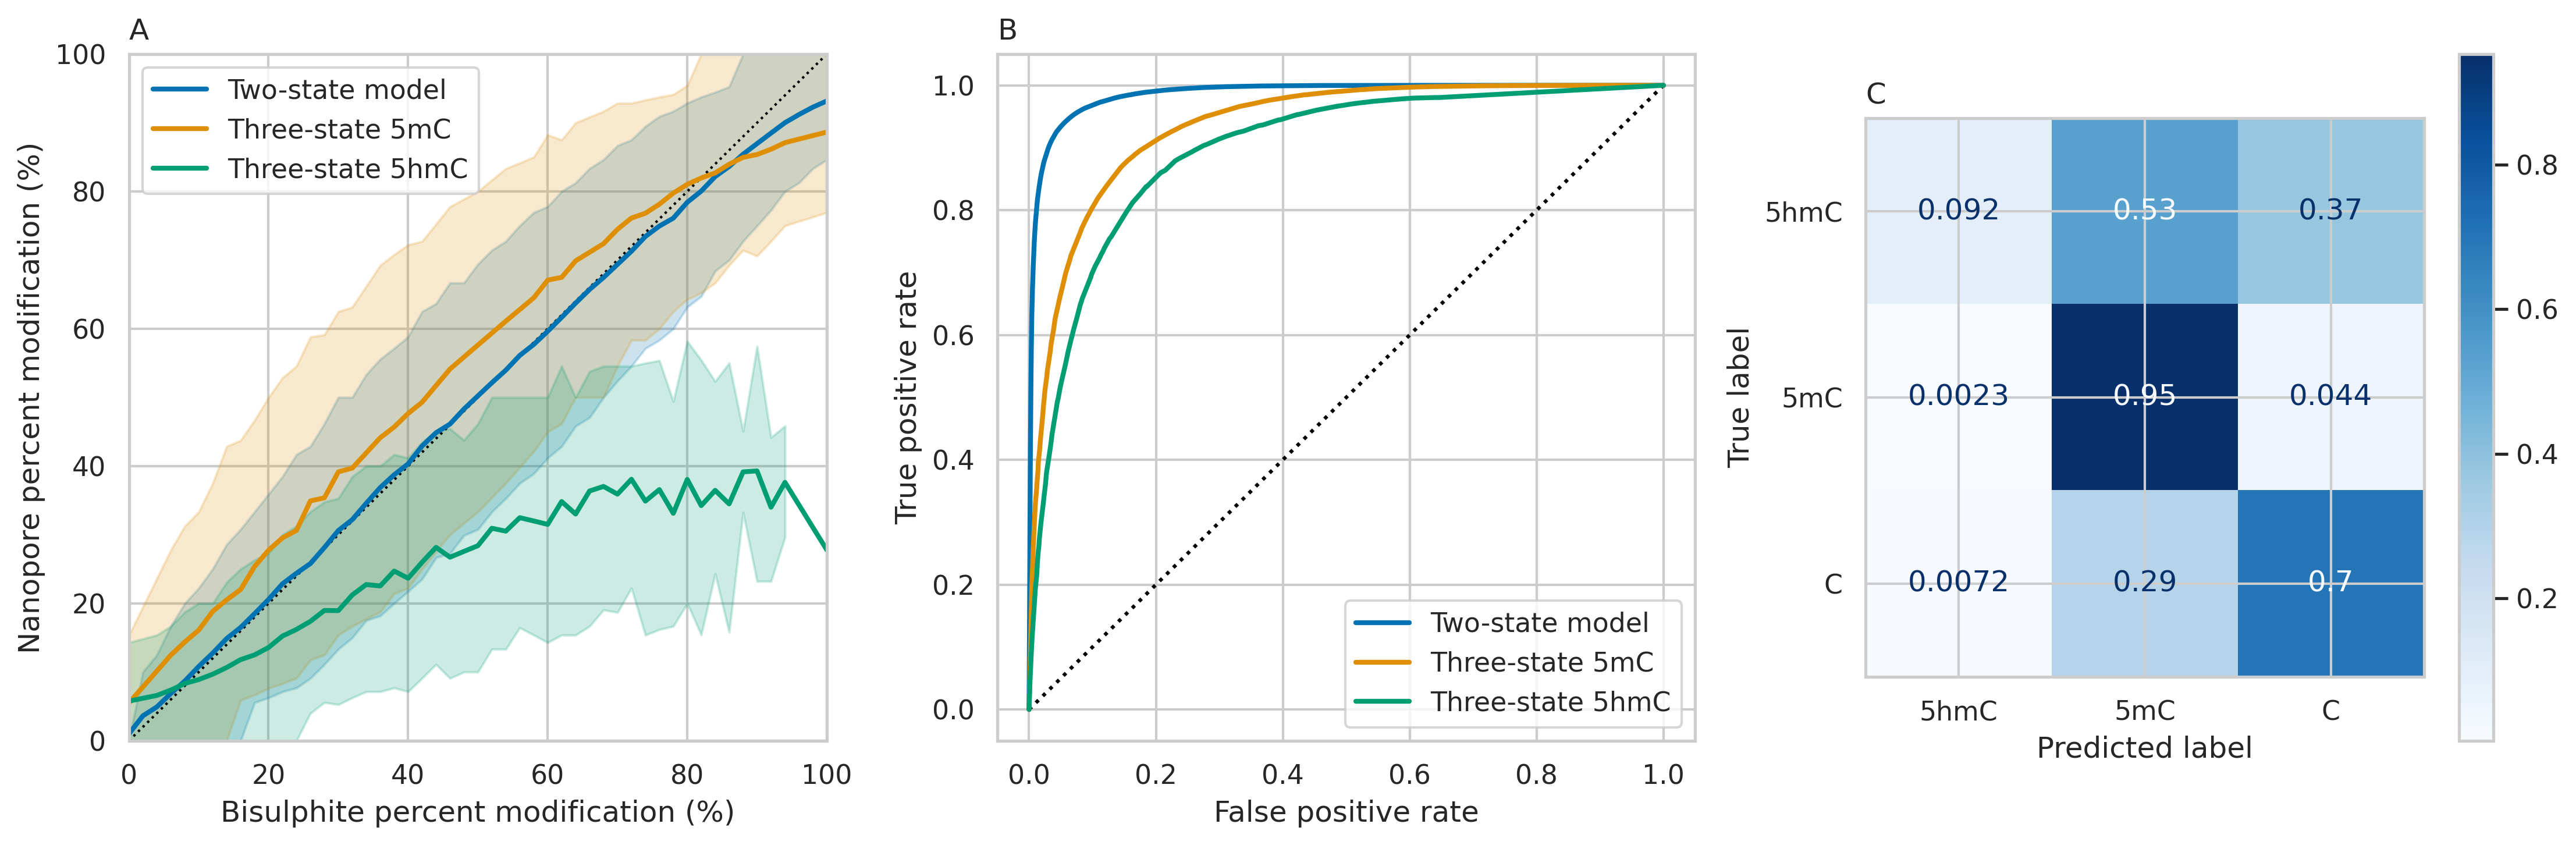

In [15]:
sns.set_theme(style="whitegrid")
sns.set_palette("colorblind")

fig2 = plt.figure(dpi=300, figsize=(15, 5)) 
gs2 = GridSpec(1, 3, fig2)

ax21 = fig2.add_subplot(gs2[0, 0])
ax21.plot(np.arange(0, 105, 5), np.arange(0, 105, 5), linestyle=":", lw=1, color="black")
sns.lineplot(binBenchmark(two_mod_wide), x="bin", y="percentMeth_Nanopore", errorbar=("pi", 75), err_style="band", label="Two-state model", linewidth=2, ax=ax21)
sns.lineplot(binBenchmark(mc_df_wide), x="bin", y="percentMeth_Nanopore", errorbar=("pi", 75), err_style="band", label="Three-state 5mC", linewidth=2, ax=ax21)
sns.lineplot(binBenchmark(hmc_df_wide), x="bin", y="percentMeth_Nanopore", errorbar=("pi", 75), err_style="band", label="Three-state 5hmC", linewidth=2, ax=ax21)
ax21.legend()
sns.move_legend(ax21, "upper left")
ax21.set_ylim((0, 100))
ax21.set_xlim((0, 100))
ax21.set_xlabel("Bisulphite percent modification (%)")
ax21.set_ylabel("Nanopore percent modification (%)")
ax21.set_title("A", loc="left")

ax24 = fig2.add_subplot(gs2[0, 1])
ax24.plot(np.arange(0, 1.1, 0.1), np.arange(0, 1.1, 0.1), "black", linestyle=":")
ROCmain(two_mod_wide, ax24, "Two-state model")
ROCmain(mc_df_wide, ax24, "Three-state 5mC")
ROCmain(hmc_df_wide, ax24, "Three-state 5hmC")
ax24.set_xlabel("False positive rate")
ax24.set_ylabel("True positive rate")
ax24.legend()
sns.move_legend(ax24, "lower right")
ax24.set_title("B", loc="left")

ax25 = fig2.add_subplot(gs2[0, 2])
ConfusionMatrixDisplay.from_predictions(defineTruthset(), definePredictions(), normalize="true", cmap="Blues", ax=ax25)
ax25.set_title("C", loc="left")

fig2.tight_layout()

In [7]:

def threeModDFtoPyrange():
    data = merge3Mod()

    pyrange = pr.from_dict({
        "Chromosome" : data["chromosome"],
        "Start" : data["chromStart"],
        "End" : data["chromEnd"],
        "Strand" : data["strand_5hmC"],
        "percentMeth_Nanopore_5hmC" : data["percentMeth_Nanopore_5hmC"], 
        "percentMeth_Bisulphite_5hmC" : data["percentMeth_Bisulphite_5hmC"]
        }
        )
    return pyrange

three_mod_pr = threeModDFtoPyrange()

def intersectWithGene():
    pyrange = three_mod_pr
    gene_ref = pd.read_csv('./feature_references/revised/GENCODE_Basic_mm39_Genes_merged.bed', sep="\t", 
                           names=["Chromosome", "Start", "End", "geneName", "Strand"])    
    return pyrange.join(pr.PyRanges(gene_ref), strandedness="same")

def convertToGeneDF():
    pyrange = intersectWithGene()
    gene_df = pyrange.as_df().groupby(["geneName"])[["percentMeth_Nanopore_5hmC", "percentMeth_Bisulphite_5hmC"]].agg([np.mean, "count"])
    return gene_df.reset_index()

def log2MeanDF():
    gene_df = convertToGeneDF()
    nanopore_mean = np.mean(gene_df["percentMeth_Nanopore_5hmC"]["mean"])
    bisulphite_mean = np.mean(gene_df["percentMeth_Bisulphite_5hmC"]["mean"])

    with np.errstate(divide="ignore"):
        gene_df["Log2FromMean_Nanopore"] = np.log2(
            np.divide(gene_df["percentMeth_Nanopore_5hmC"]["mean"],
                    nanopore_mean)
        )
        gene_df["Log2FromMean_Bisulphite"] = np.log2(
            np.divide(gene_df["percentMeth_Bisulphite_5hmC"]["mean"],
                    bisulphite_mean)
        )
    gene_df = gene_df.replace(-np.inf, np.nan)
    return gene_df.dropna()    

def makeRefDF(path, feature_type):
    columns = ["Chromosome","Start","End","Name","Score","Strand","feature_type"]
    df = pd.read_csv(path, sep="\t", names=columns)
    df["feature_type"] = feature_type
    return df

def makeFeatureRefDF():
    gene_feature_list = subprocess.check_output(["ls", "./feature_references/revised/gene_features/"]).decode("utf-8").split("\n") 
    gene_feature_list.pop(-1)

    df_list = []
    for file in gene_feature_list:
        path = "./feature_references/revised/gene_features/" + file
        columns = ["Chromosome","Start","End","Name","Score","Strand"]
        df = pd.read_csv(path, sep="\t", names=columns)
        df["feature_type"] = file.split("_")[3]
        df_list.append(df)

    feature_reference_df = pd.concat(df_list)
    return feature_reference_df

def makeCGIrefDF():
    cgi_feature_list = subprocess.check_output(["ls", "./feature_references/revised/cgi/"]).decode("utf-8").split("\n") 
    cgi_feature_list.pop(-1)

    cgi_df_list = []
    for file in cgi_feature_list:
        path = "./feature_references/revised/cgi/" + file
        columns = ["Chromosome","Start","End","Name","feature_type"]
        df = pd.read_csv(path, sep="\t", names=columns)
        cgi_df_list.append(df)

    cgi_reference_df = pd.concat(cgi_df_list)
    return cgi_reference_df

def meltMethod(input_df):
    df_melt = input_df.melt(
        ["Chromosome", "Start", "End", "Strand", "feature_type"], 
        ["percentMeth_Nanopore_5hmC", "percentMeth_Bisulphite_5hmC"], 
        "method", 
        value_name="percentMeth"
                    )
    return df_melt

def replaceMethod(input_df):
    df_with_replacement = input_df.replace(["percentMeth_Nanopore_5hmC", "percentMeth_Bisulphite_5hmC"], ["Nanopore 5hmC", "TAB"])
    return df_with_replacement

def categoriseGeneFeatures(input_df):
    categorised_features = input_df.copy()
    categorised_features["feature_type"] = pd.Categorical(
        categorised_features["feature_type"], 
        ["Intergenic", "Promoter", "5UTR", "TSS", "Intron", "Exon", "3UTR", "TTS"])
    return categorised_features
        
def categoriseCGI(input_df):
    categorised_features = input_df.copy()
    categorised_features["feature_type"] = pd.Categorical(
        categorised_features["feature_type"], ["Open sea", "Upstream shelf", "Upstream shore", "CGI", "Downstream shore", "Downstream shelf"])
    return categorised_features
        
def intersectWithFeatures(input_df, categorise=None):

    if categorise == "Gene features":
        ref_features = pr.PyRanges(makeFeatureRefDF())
        feature_intersect = input_df.join(ref_features)
        feature_intersect_df = meltMethod(feature_intersect.as_df())
        feature_intersect_df = replaceMethod(feature_intersect_df)
        feature_intersect_df = categoriseGeneFeatures(feature_intersect_df)

    elif categorise == "CGI":
        ref_features = pr.PyRanges(makeCGIrefDF())
        feature_intersect = input_df.join(ref_features)
        feature_intersect_df = meltMethod(feature_intersect.as_df())
        feature_intersect_df = replaceMethod(feature_intersect_df)
        feature_intersect_df = categoriseCGI(feature_intersect_df)
        
    return feature_intersect_df

def featureLinePlotMain():
    input_df = three_mod_pr
    output_df = intersectWithFeatures(input_df, "Gene features")
    return output_df

def cgiLinePlotMain():
    input_df = three_mod_pr
    output_df = intersectWithFeatures(input_df, "CGI")
    return output_df


In [8]:
log2_mean_df = log2MeanDF()

In [9]:
def findDifference():
    gene_df = log2_mean_df
    gene_df["Difference"] = np.subtract(gene_df["Log2FromMean_Bisulphite"], gene_df["Log2FromMean_Nanopore"])
    # gene_df = gene_df.loc[gene_df["percentMeth_Bisulphite_5hmC"]["count"] > 20]
    return gene_df

def defineHighestConsensusGenesDF():
    df = findDifference()
    df["DifferenceAbs"] = np.absolute(df["Difference"])
    closest_genes_df = df.nsmallest(100, "DifferenceAbs")
    closest_genes_df["Average"] = closest_genes_df[["Log2FromMean_Bisulphite", "Log2FromMean_Nanopore"]].mean(axis=1)
    return closest_genes_df.sort_values("Average", ascending=False)

def defineLowestConsensusGenesDF():
    df = findDifference()
    df["DifferenceAbs"] = np.absolute(df["Difference"])
    closest_genes_df = df.nsmallest(100, "DifferenceAbs")
    closest_genes_df["Average"] = closest_genes_df[["Log2FromMean_Bisulphite", "Log2FromMean_Nanopore"]].mean(axis=1)
    return closest_genes_df.sort_values("Average", ascending=True)

def defineHighestInTabDF():
    df = findDifference()
    # df = df.loc[(df["Difference"] > 0.5)]
    highest_tab_df = df.loc[round(df["Log2FromMean_Nanopore"]) == 0]
    highest_tab_df = highest_tab_df.nlargest(100, "Log2FromMean_Bisulphite")

    return highest_tab_df.sort_values("Log2FromMean_Bisulphite", ascending=False)

def defineHighestInNanoporeDF():
    df = findDifference()
    # df = df.loc[df["Difference"] < -0.5]
    highest_nanopore_df = df.loc[round(df["Log2FromMean_Bisulphite"]) == 0]
    highest_nanopore_df = highest_nanopore_df.nlargest(100, "Log2FromMean_Nanopore")

    return highest_nanopore_df.sort_values("Log2FromMean_Nanopore", ascending=False)

In [9]:
def selectGenes():
    gene_df = findDifference()
        gene_df["Count"] = gene_df["percentMeth_Bisulphite_5hmC"]["count"]
        genes = gene_df.loc[
            (gene_df["Log2FromMean_Nanopore"] >= lim) & 
            (gene_df["Log2FromMean_Nanopore"] <= lim + 1) & 
            (gene_df["Log2FromMean_Bisulphite"] >= lim) &
            (gene_df["Log2FromMean_Bisulphite"] <= lim + 1)]
        select_df = genes.nlargest(3, "Count")

IndentationError: unexpected indent (3095360282.py, line 3)

NameError: name 'log2_mean_df' is not defined

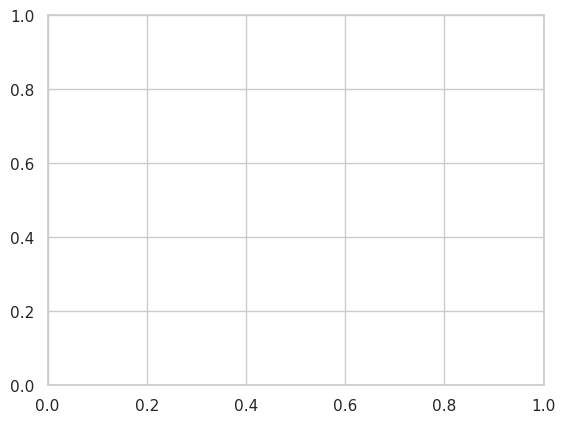

In [18]:
fig, ax = plt.subplots()

sns.histplot(log2_mean_df, x="Log2FromMean_Bisulphite", y="Log2FromMean_Nanopore", cbar=True, stat="count",
             cbar_kws={"label" : "Number of genes", 
                       "format" : "%d"}
             )

ax.plot(np.arange(-5, 4, 1), np.arange(-5, 4, 1), color="black", linestyle=":")

for lim in np.arange(-4, 4):
    gene_df = findDifference()
    gene_df["Count"] = gene_df["percentMeth_Bisulphite_5hmC"]["count"]
    genes = gene_df.loc[
        (gene_df["Log2FromMean_Nanopore"] >= lim) & 
        (gene_df["Log2FromMean_Nanopore"] <= lim + 1) & 
        (gene_df["Log2FromMean_Bisulphite"] >= lim) &
        (gene_df["Log2FromMean_Bisulphite"] <= lim + 1)]
    select_df = genes.nlargest(3, "Count")
    sns.scatterplot(select_df, x="Log2FromMean_Bisulphite", y="Log2FromMean_Nanopore", ax=ax)
    
    

In [23]:
featureLinePlot_df = featureLinePlotMain()
cgiLinePlot_df = cgiLinePlotMain() 

KeyboardInterrupt: 

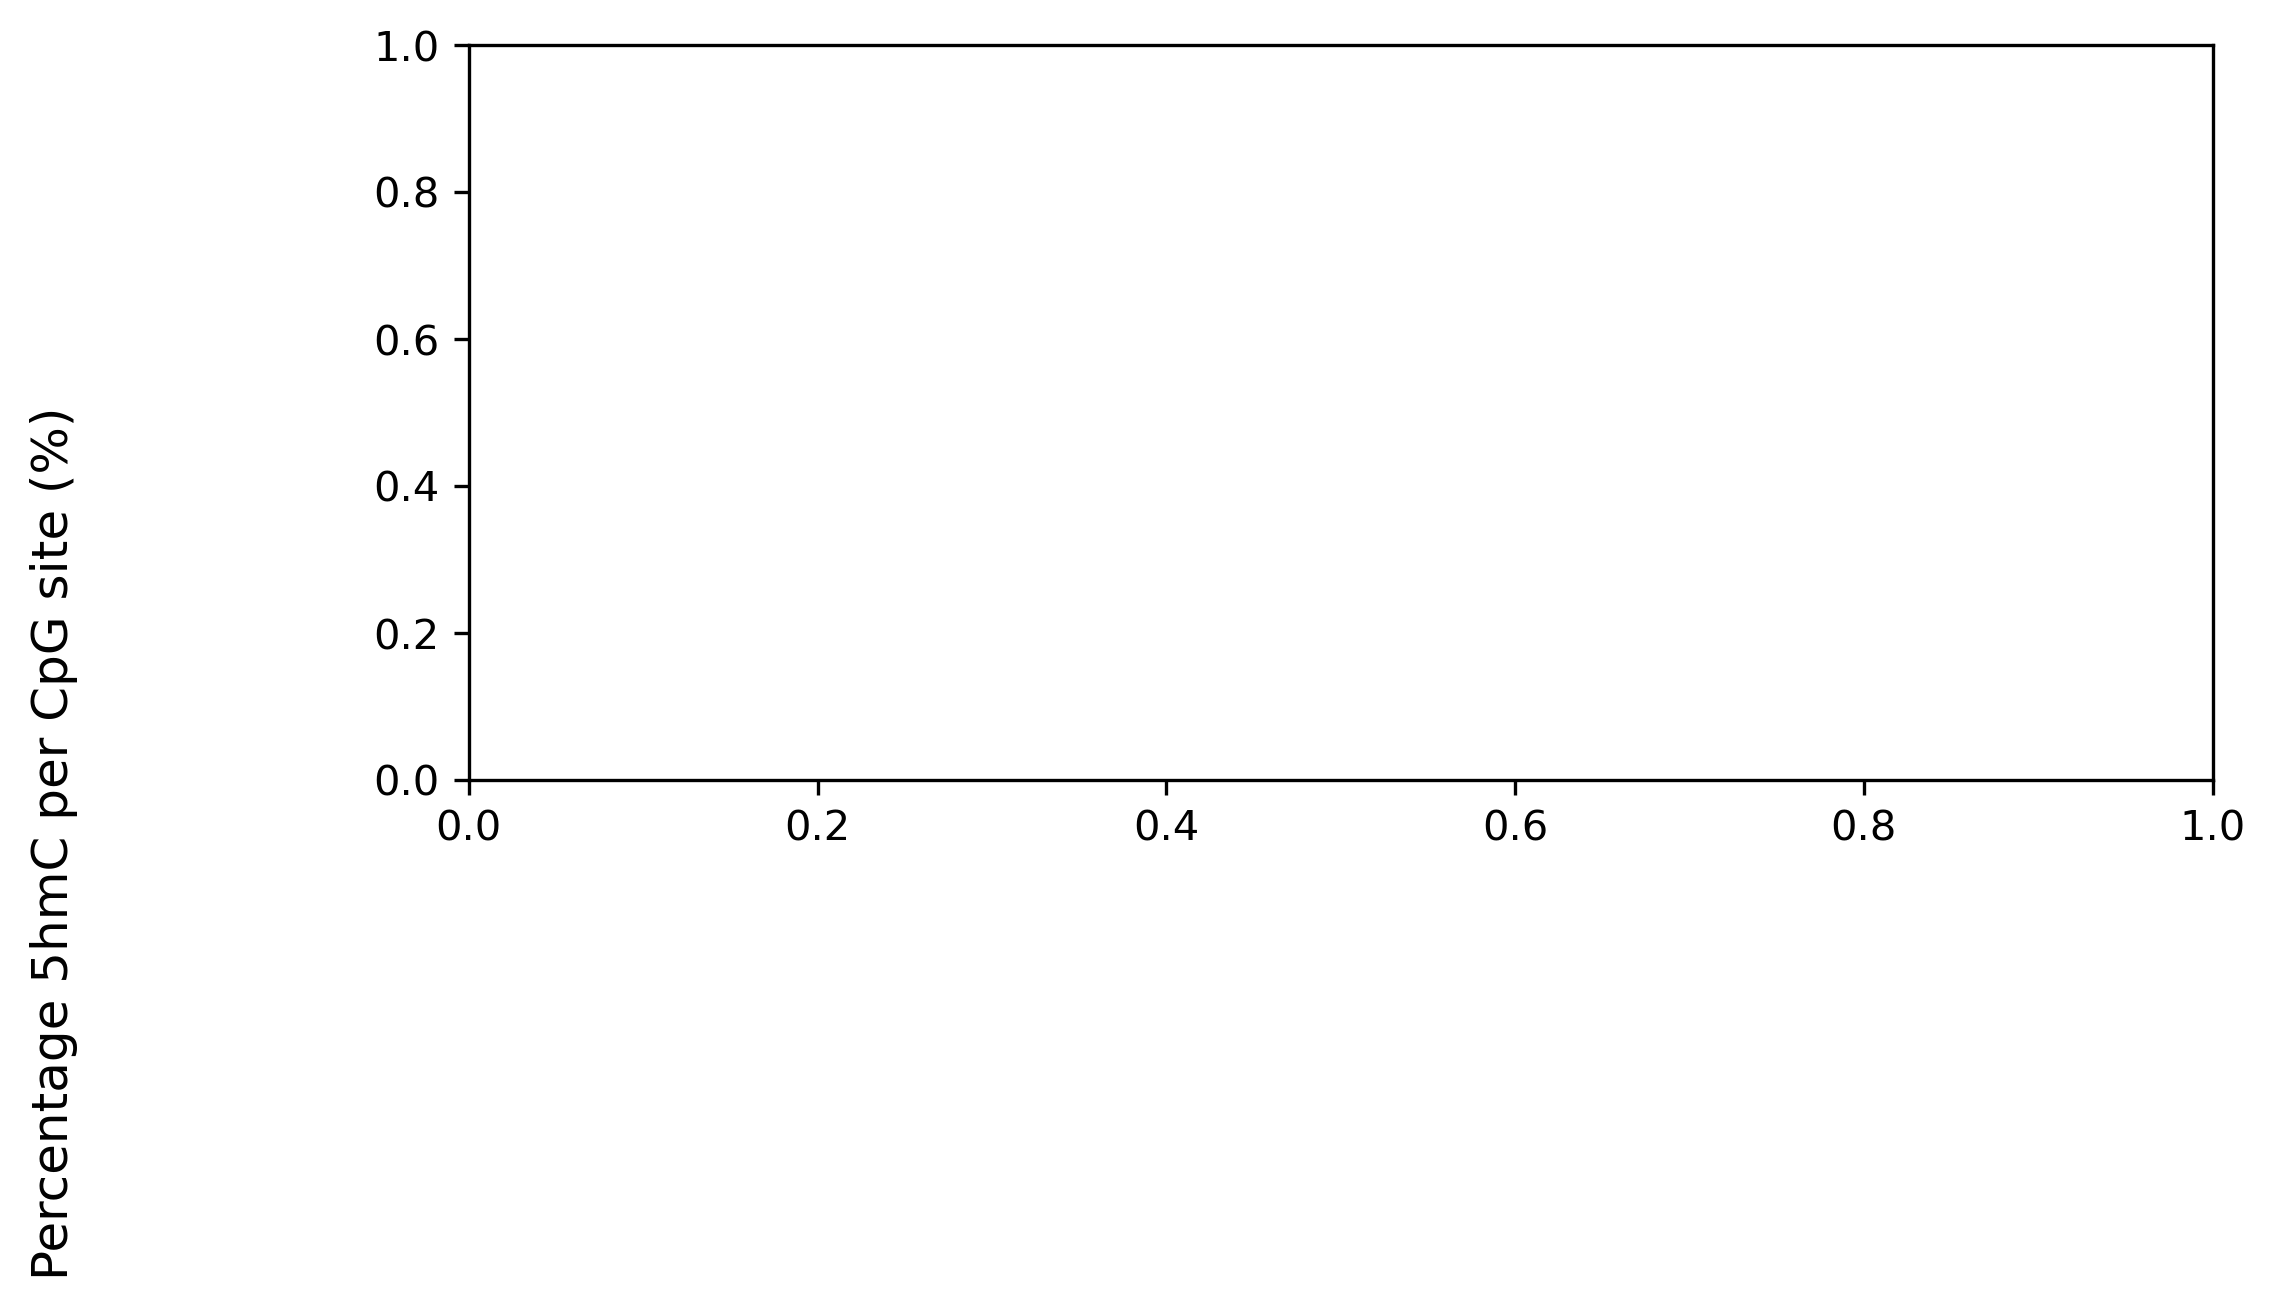

In [13]:
fig3 = plt.figure(dpi=300, figsize=(15, 7))
gs3 = GridSpec(1, 2, fig3)

fig32 = fig3.add_subfigure(gs3[:, 0])
fig32.supylabel("Percentage 5hmC per CpG site (%)", x=-0.07)
gs32 = GridSpec(2, 1, fig32)

ax32 = fig32.add_subplot(gs32[0, :])

sns.barplot(featureLinePlot_df, x="feature_type", y="percentMeth", hue="method", capsize=0.05, errwidth=1, ax=ax32)
ax32.set_xlabel("CpG context (genomic)")
ax32.set_ylabel(None)
ax32.set_ylim((0, 15))
ax32.set_title("A", loc="left")
sns.move_legend(ax32, "lower right", title=None)

ax33 = fig32.add_subplot(gs32[1, :])

sns.lineplot(cgiLinePlot_df, x="feature_type", y="percentMeth", hue="method", style="method", errorbar=("ci", 50), err_style="band", ax=ax33)
ax33.set_xlabel("CpG context (relative to CGI)")
ax33.set_ylabel(None)
ax33.set_ylim((0, 15))
ax33.set_title("B", loc="left")
# ax33.tick_params("x", rotation=10, zorder=10)
ax33.set_xticklabels(["Open\nsea", "Upstream\nshelf", "Upstream\nshore", 
                      "Island", "Downstream\nshore", "Downstream\nshelf"])
sns.move_legend(ax33, "lower right", title=None)

fig31 = fig3.add_subfigure(gs3[0, 1])
ax31 = fig31.add_subplot()

sns.histplot(log2_mean_df, x="Log2FromMean_Bisulphite", y="Log2FromMean_Nanopore", cbar=True, stat="count",
             cbar_kws={"label" : "Number of genes", 
                       "format" : "%d",
                       "shrink" : 0.3},
                       ax=ax31
             )
ax31.plot(np.arange(-5.5, 4, 1), np.arange(-5.5, 4, 1), color="black", linestyle=":")
# sns.scatterplot(findClosest().head(10).sort_values("Log2FromMean_Bisulphite", ascending=False), 
#            x="Log2FromMean_Bisulphite", y="Log2FromMean_Nanopore", color="red")

sns.scatterplot(defineHighestInTabDF().head(10), x="Log2FromMean_Bisulphite", y="Log2FromMean_Nanopore", label="Higher in TAB", ax=ax31)
sns.scatterplot(defineHighestInNanoporeDF().head(10), x="Log2FromMean_Bisulphite", y="Log2FromMean_Nanopore", label="Higher in Nanopore", ax=ax31)
sns.scatterplot(defineHighestConsensusGenesDF().head(10), x="Log2FromMean_Bisulphite", y="Log2FromMean_Nanopore", label="High in both", ax=ax31)

ax31.set_aspect(1)
ax31.set_ylim((-5.5, 3))
ax31.set_xlim((-5.5, 3))
ax31.set_xlabel("TAB enrichment score")
ax31.set_ylabel("Nanopore enrichment score")
ax31.set_title("C", loc="left")

gene_rho, gene_p = stats.spearmanr(log2_mean_df["Log2FromMean_Nanopore"], log2_mean_df["Log2FromMean_Bisulphite"])
ax31.text(-0.5, 2.6, "Spearman \u03C1 = {rho:.2f}".format(rho=gene_rho), ha="center")

fig3.tight_layout(pad=4)

# PowerPoint style figures

These figures have been modified for standard PowerPoint dimensions to be used in presentations.

/mnt/data1/doh28/tools/condas/GeneralAnalysis/lib/python3.9/site-packages/seaborn/utils.py:482: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  new_legend = legend_func(handles, labels, loc=loc, **props)


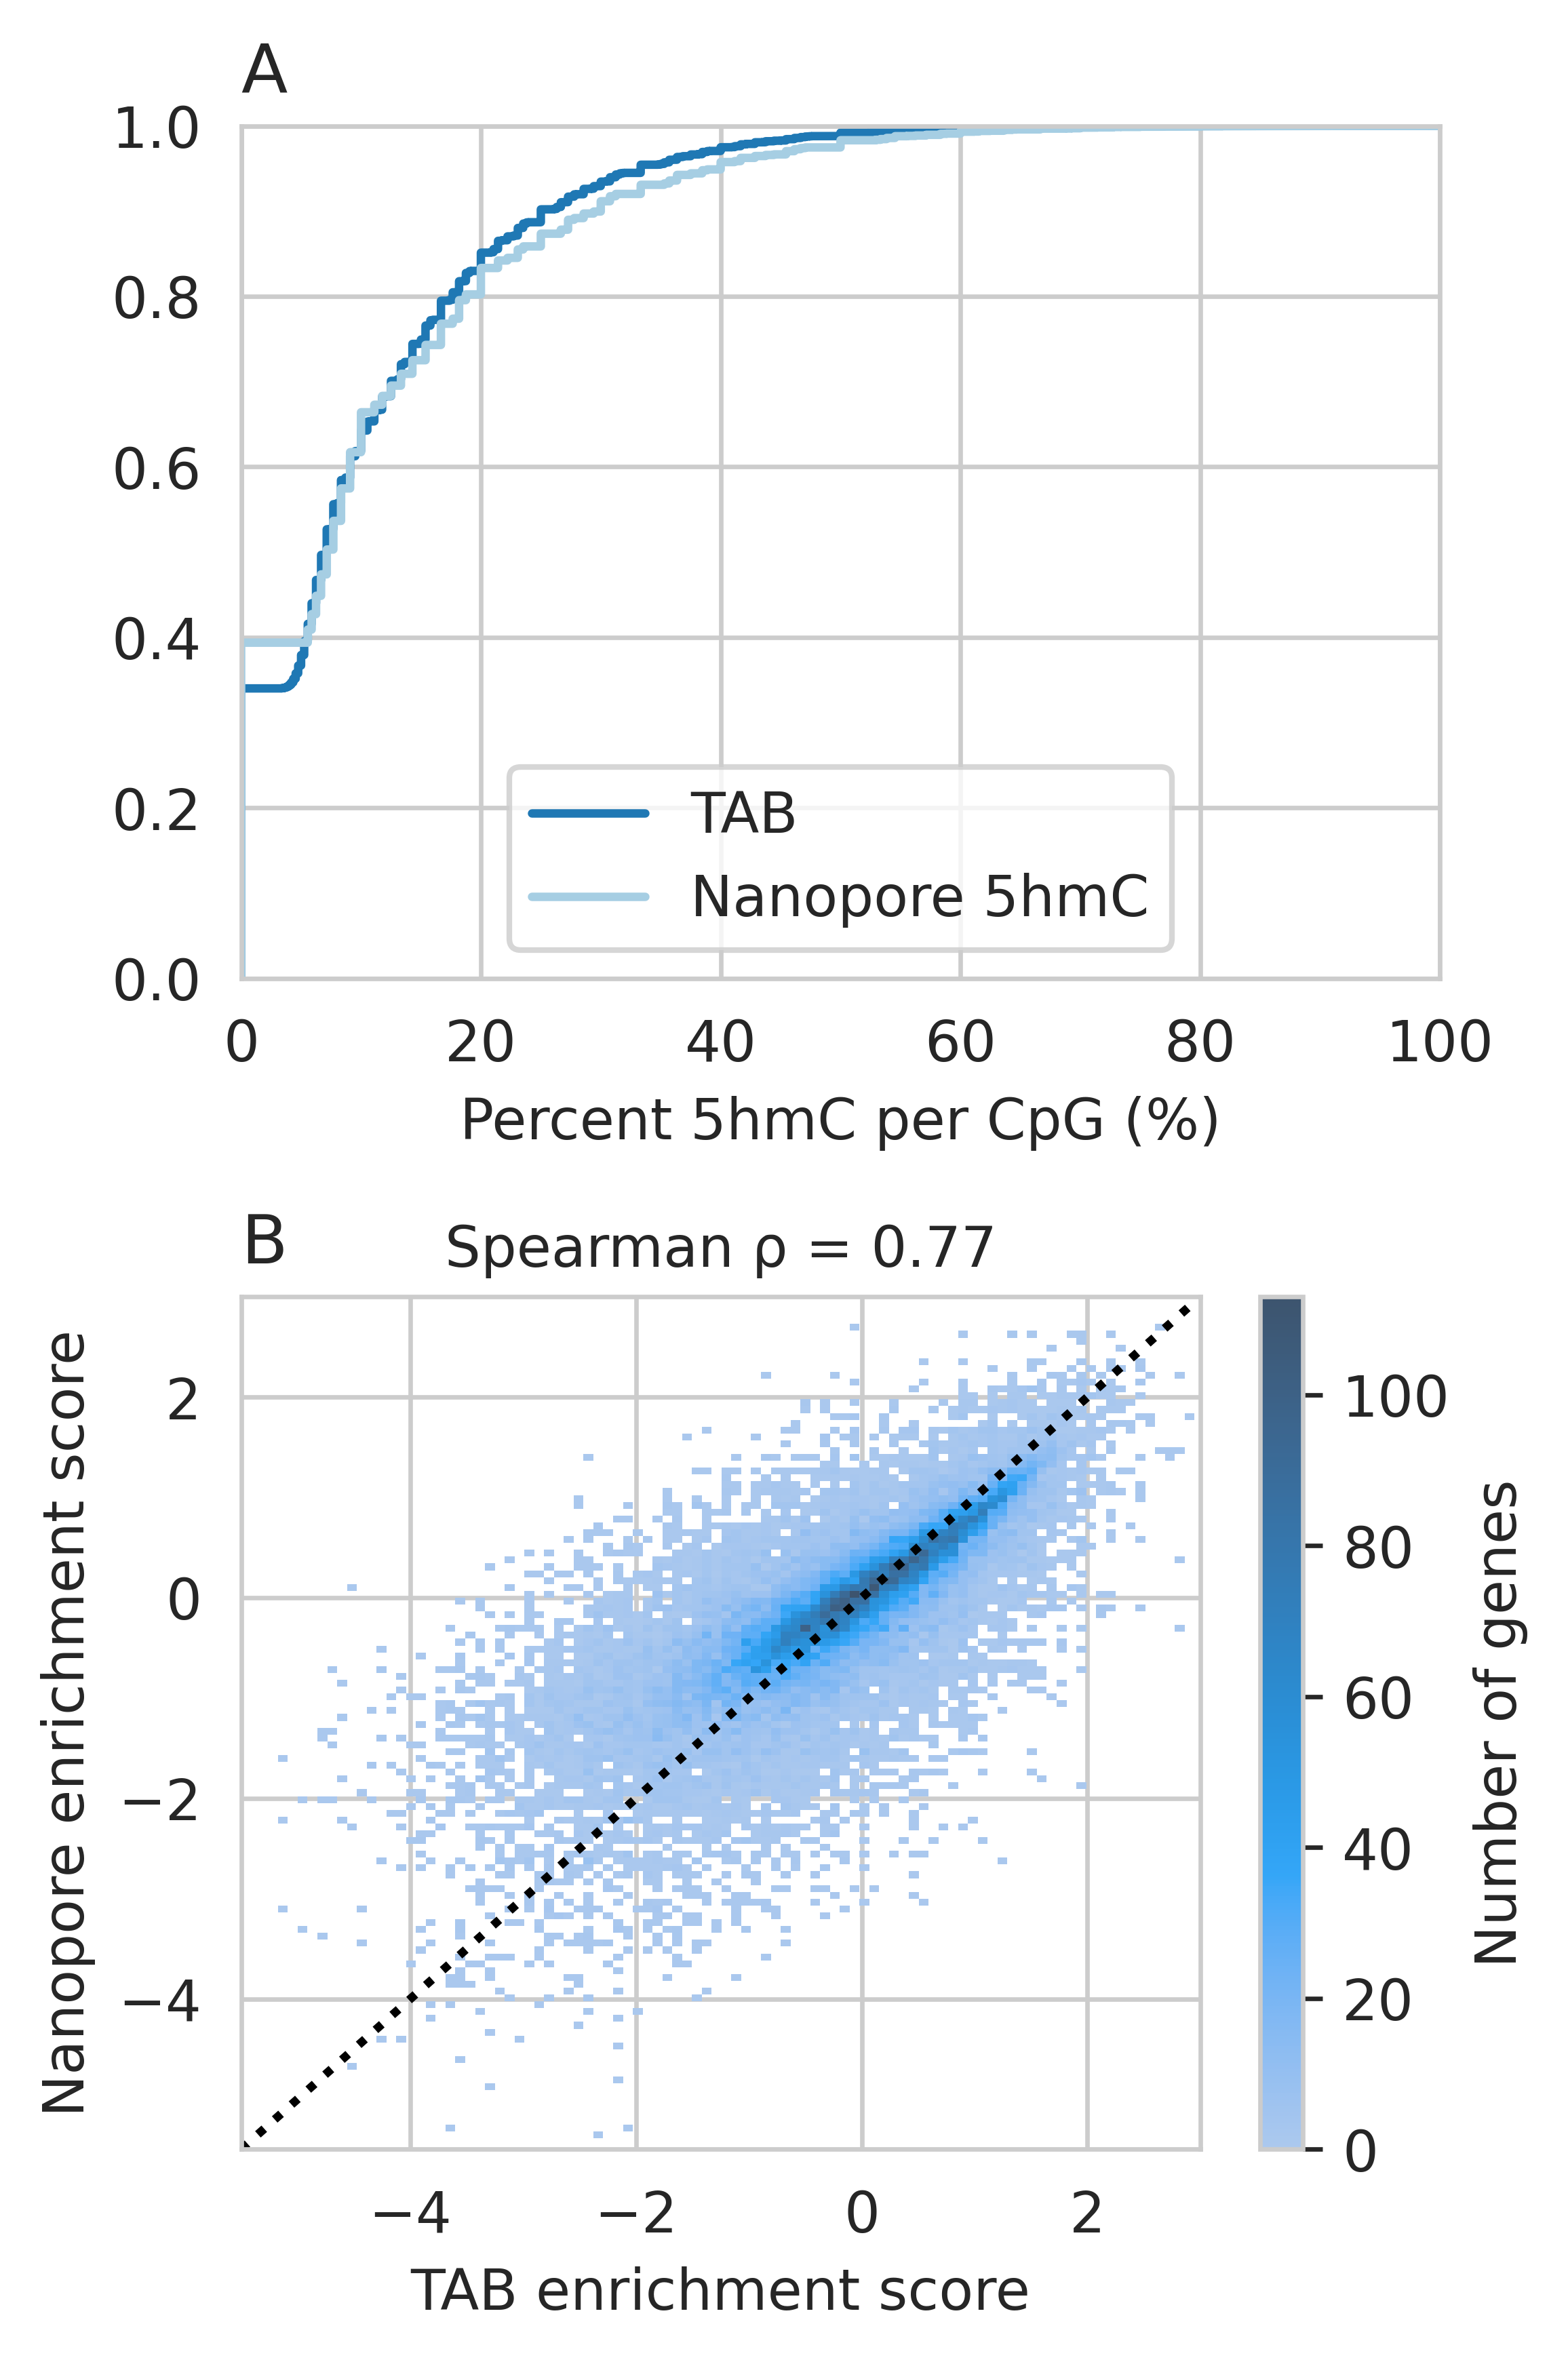

In [27]:
sns.set_style("whitegrid")

fig = plt.figure(figsize=((10)/2.54, (15)/2.54), dpi=600, facecolor="None")
gs = GridSpec(2, 1, fig)

ax1 = fig.add_subplot(gs[0, :])
sns.ecdfplot(hmc_df_long, x="percentMeth", hue="method", palette="Paired", ax=ax1)
sns.move_legend(ax1, "lower center", title=None, labels=["TAB", "Nanopore 5hmC"])
ax1.set_ylabel(None)
ax1.set_xlabel("Percent 5hmC per CpG (%)")
ax1.set_xlim([0, 100])
ax1.set_title("A", loc="left")

ax2 = fig.add_subplot(gs[1, :])

sns.histplot(log2_mean_df, x="Log2FromMean_Bisulphite", y="Log2FromMean_Nanopore", cbar=True, stat="count",
             cbar_kws={"label" : "Number of genes", 
                       "format" : "%d"},
                       ax=ax2)
ax2.plot(np.arange(-5.5, 4, 1), np.arange(-5.5, 4, 1), color="black", linestyle=":")
ax2.set_ylim((-5.5, 3))
ax2.set_xlim((-5.5, 3))

gene_rho, gene_p = stats.spearmanr(log2_mean_df["Log2FromMean_Nanopore"], log2_mean_df["Log2FromMean_Bisulphite"])
ax2.text(3-(5.5+3)/2, 3.3, "Spearman \u03C1 = {rho:.2f}".format(rho=gene_rho), ha="center")

ax2.set_xlabel("TAB enrichment score")
ax2.set_ylabel("Nanopore enrichment score")
ax2.set_title("B", loc="left")

fig.tight_layout()

/tmp/ipykernel_473504/4271380038.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax33.set_xticklabels(["Open\nsea", "Upstream\nshelf", "Upstream\nshore",


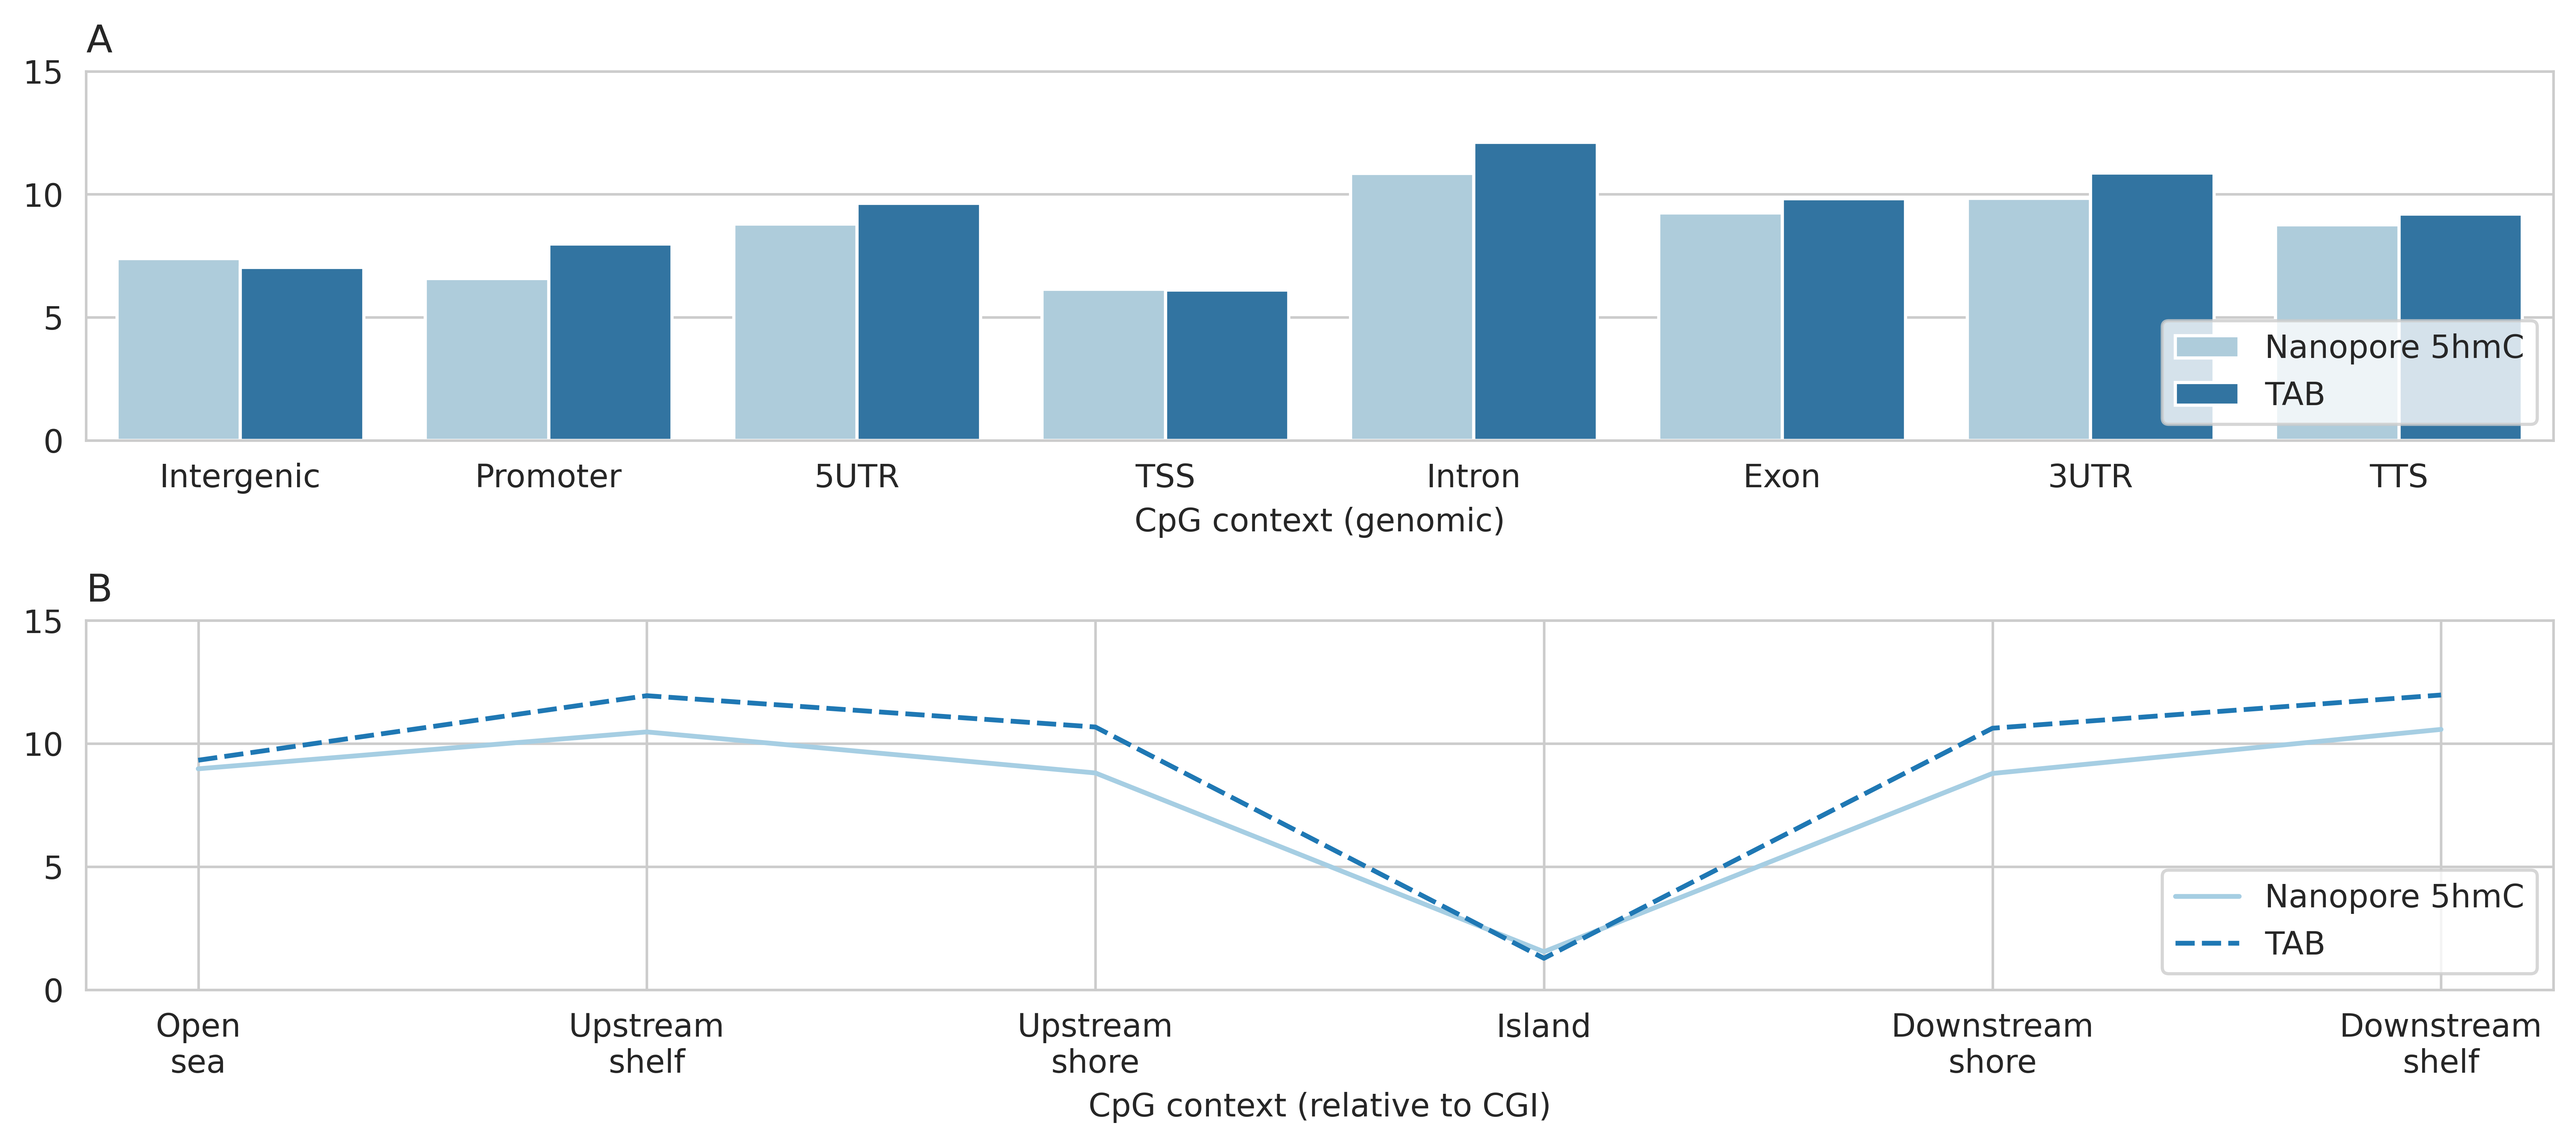

In [31]:
fig = plt.figure(figsize=((29.1)/2.54, (12.9)/2.54), dpi=600, facecolor="None")
gs = GridSpec(2, 1, fig)

sns.set_palette("Paired")

ax32 = fig.add_subplot(gs[0, :])

sns.barplot(featureLinePlot_df, x="feature_type", y="percentMeth", hue="method", errorbar=None, ax=ax32)
ax32.set_xlabel("CpG context (genomic)")
ax32.set_ylabel(None)
ax32.set_ylim((0, 15))
ax32.set_title("A", loc="left")
sns.move_legend(ax32, "lower right", title=None)    

ax33 = fig.add_subplot(gs[1, :])

sns.lineplot(cgiLinePlot_df, x="feature_type", y="percentMeth", hue="method", style="method", errorbar=None, ax=ax33)
ax33.set_xlabel("CpG context (relative to CGI)")
ax33.set_ylabel(None)
ax33.set_ylim((0, 15))
ax33.set_title("B", loc="left")
# ax33.tick_params("x", rotation=10, zorder=10)
ax33.set_xticklabels(["Open\nsea", "Upstream\nshelf", "Upstream\nshore", 
                      "Island", "Downstream\nshore", "Downstream\nshelf"])
sns.move_legend(ax33, "lower right", title=None)

fig.tight_layout()

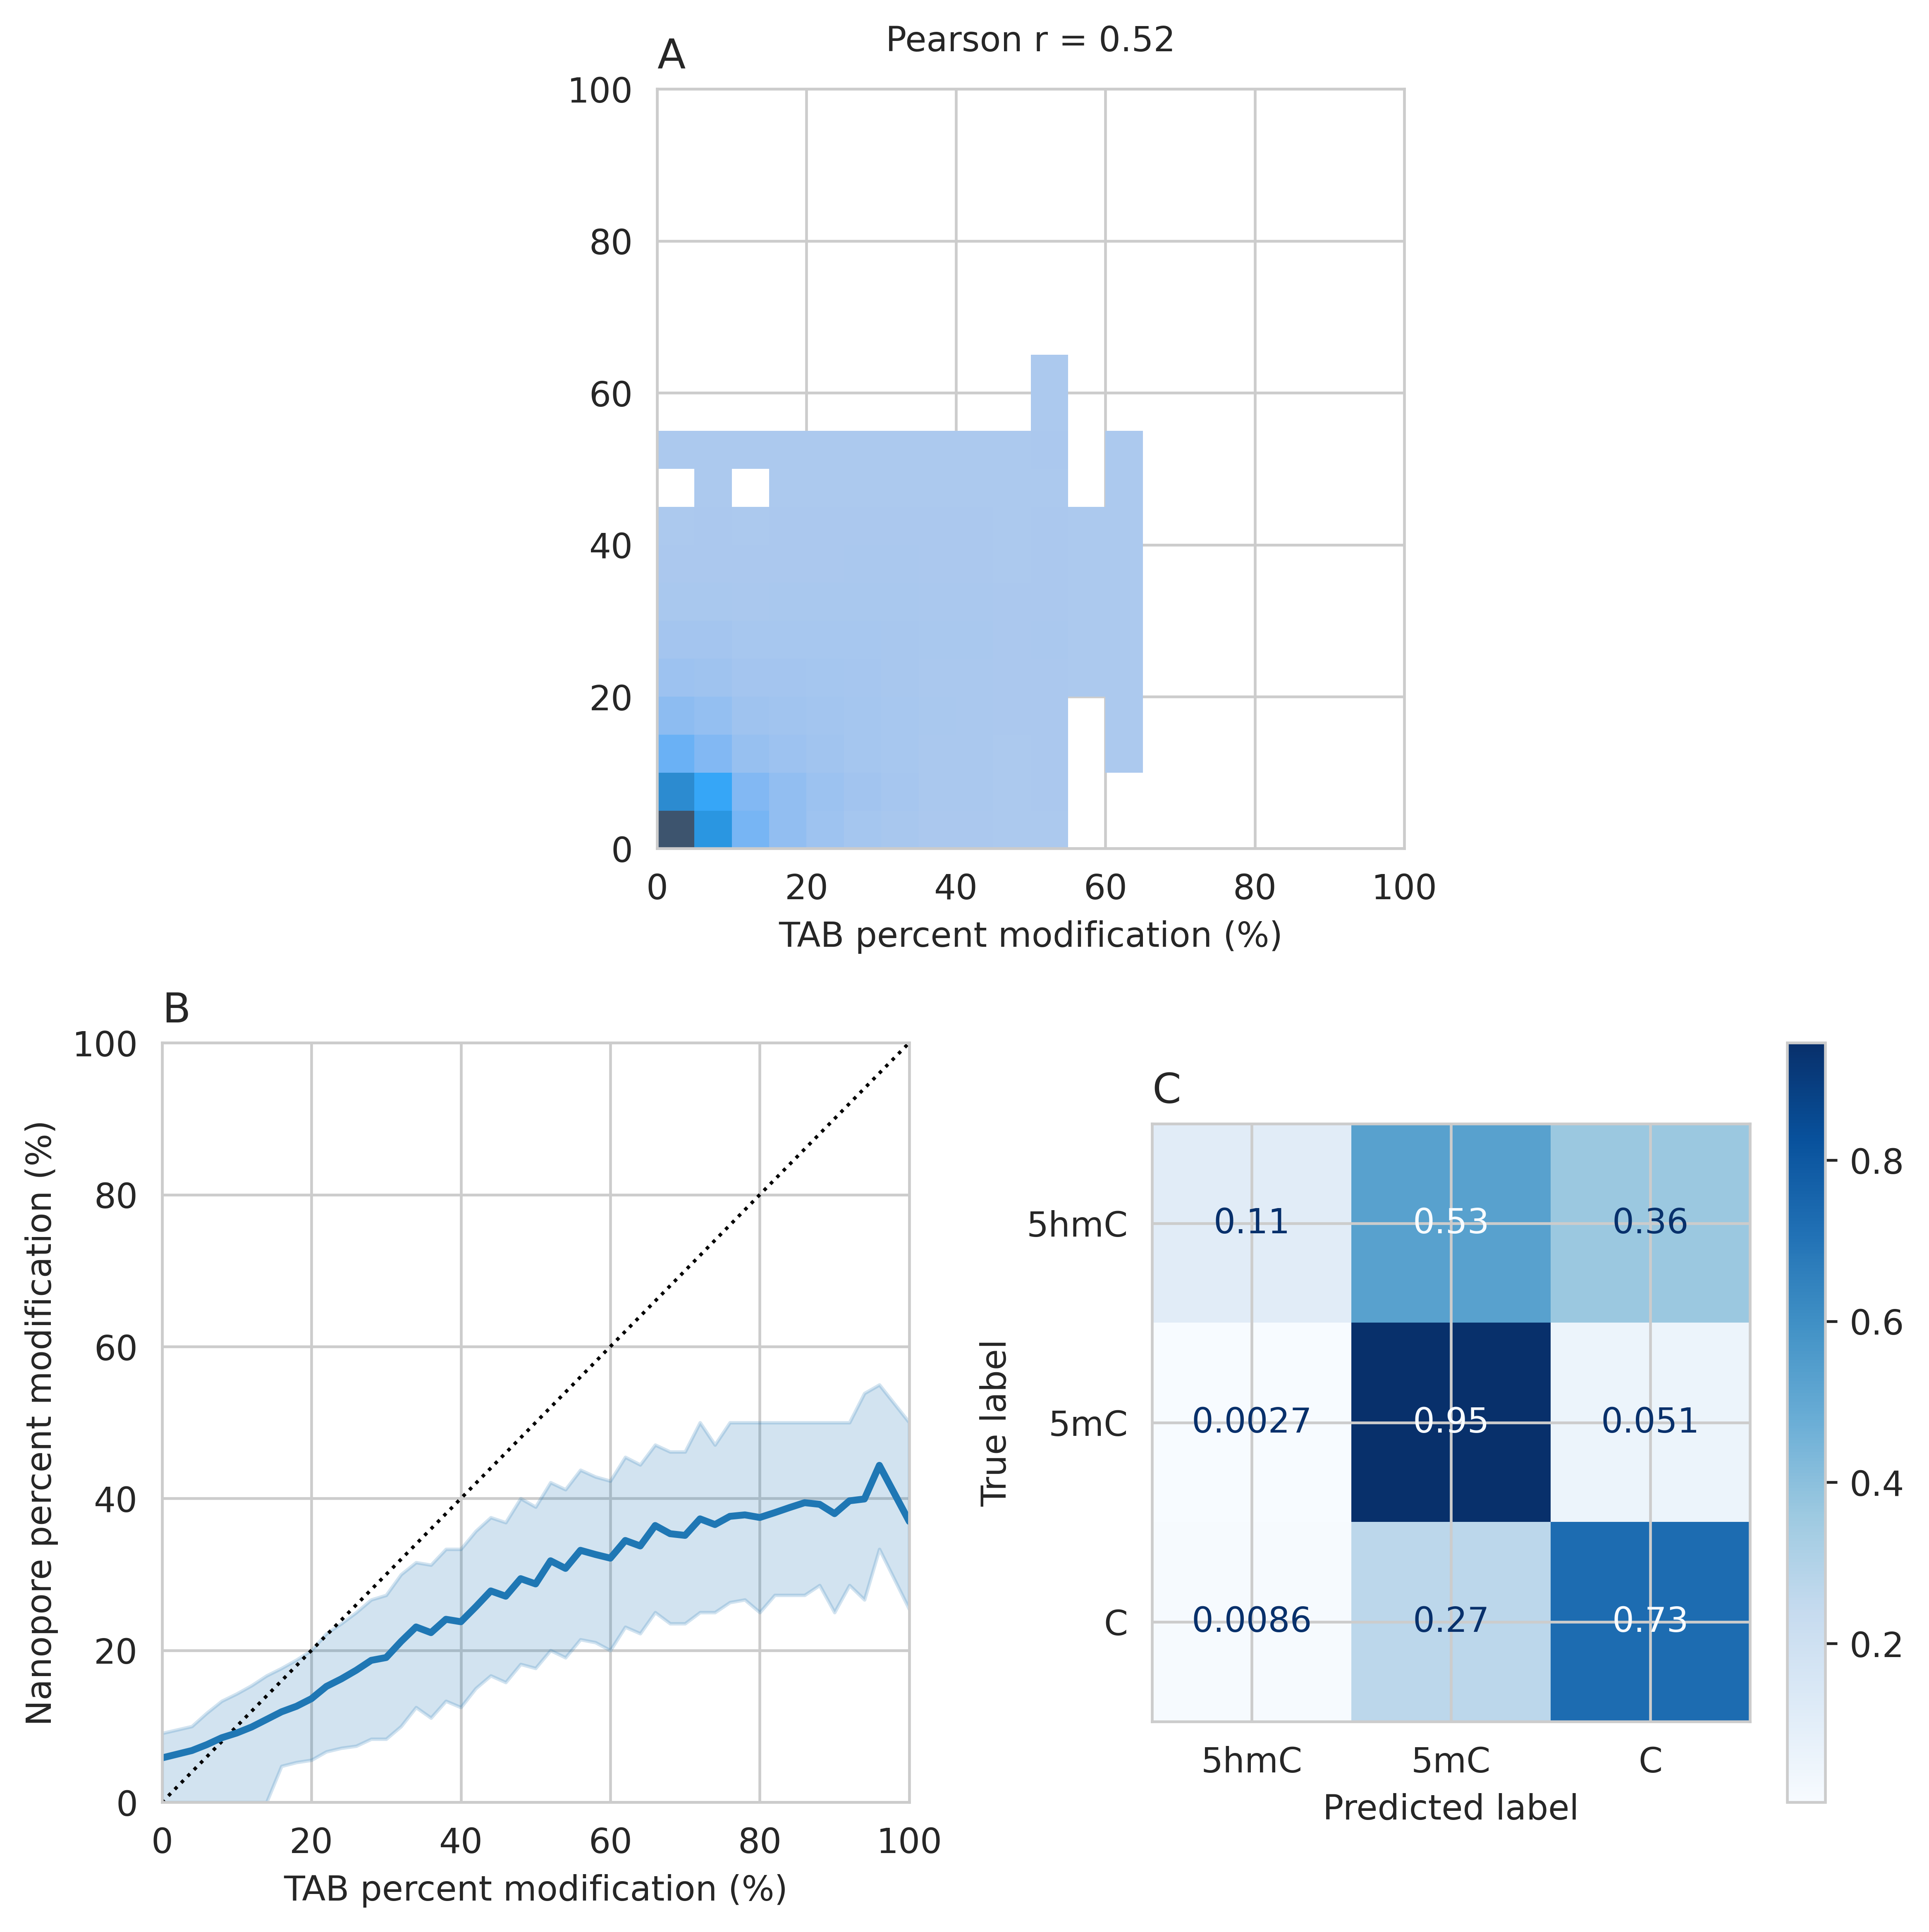

In [23]:
sns.set_style("whitegrid")

fig = plt.figure(figsize=((20)/2.54, (20)/2.54), dpi=600, facecolor="None")
gs = GridSpec(2, 4, fig)

ax1 = fig.add_subplot(gs[0, 1:3])
sns.histplot(hmc_df_wide, x="percentMeth_Bisulphite", y="percentMeth_Nanopore", bins=20, pthresh=0.01, stat="density", ax=ax1)
ax1.text(50, 105, "Pearson r = {r:.2f}".format(r=calcPearson(hmc_df_wide)[0]), ha="center")
ax1.set_xlim((0, 100))
ax1.set_ylim((0, 100))
ax1.set_xlabel("TAB percent modification (%)")
ax1.set_ylabel(None)
ax1.set_title("A", loc="left")

ax2 = fig.add_subplot(gs[1, :2])
ax2.plot(np.arange(0, 105, 5), np.arange(0, 105, 5), linestyle=":", lw=1, color="black")
sns.lineplot(binBenchmark(hmc_df_wide), x="bin", y="percentMeth_Nanopore", errorbar=("pi", 50), err_style="band", linewidth=2, ax=ax2)
ax2.set_ylim((0, 100))
ax2.set_xlim((0, 100))
ax2.set_xlabel("TAB percent modification (%)")
ax2.set_ylabel("Nanopore percent modification (%)")
ax2.set_title("B", loc="left")

ax3 = fig.add_subplot(gs[1, 2:])
ConfusionMatrixDisplay.from_predictions(defineTruthset(), definePredictions(), normalize="true", cmap="Blues", ax=ax3)
ax3.set_title("C", loc="left")

fig.tight_layout()

In [ ]:
import pyBigWig # required for bigWig output of pr 

def makeChromSizes():
    init = pd.read_csv('./feature_references/revised/mm39.chrom.sizes', sep="\t", names=["Chromosome", "End", "Start"])
    init["Start"] = 0
    init = init[["Chromosome", "Start", "End"]]
    return pr.PyRanges(init).sort()

three_mod_pr.to_bigwig('./outputs/nanopore_5hmC_chr1.bw', chromosome_sizes=makeChromSizes(), value_col="percentMeth_Nanopore_5hmC")

In [ ]:
defineHighestInTabDF()


In [ ]:
defineHighestInNanoporeDF()


In [ ]:
defineHighestConsensusGenesDF()

geneName  \
                                                           
8054   ENSMUST00000043983.11,ENSMUST00000195164.2,ENS...   
2863          ENSMUST00000023564.10,ENSMUST00000161286.8   
6665                               ENSMUST00000036509.14   
2512           ENSMUST00000022529.8,ENSMUST00000175415.3   
12805          ENSMUST00000075249.6,ENSMUST00000219063.2   
...                                                  ...   
22274                               ENSMUST00000190123.2   
15291                               ENSMUST00000096089.3   
11161  ENSMUST00000062917.16,ENSMUST00000215525.2,ENS...   
10693                               ENSMUST00000059937.5   
20552                               ENSMUST00000168646.2   

      percentMeth_Nanopore_5hmC       percentMeth_Bisulphite_5hmC        \
                           mean count                        mean count   
8054                  22.807123    73                   25.197617    73   
2863                  20.333667    30                   22.408654    30   
6665                  19.835455    11                   21.913977    11   
2512                  19.348947    19                   21.305274    19   
12805                 18.778500    20                   20.730147    20   
...                         ...   ...                         ...   ...   
22274                  4.451954    87                    4.906445    87   
15291                  4.281429    14                    4.716117    14   
11161                  3.998718    39                    4.409921    39   
10693                  3.964737    19                    4.370892    19   
20552                  2.849231    13                    3.136095    13   

      Log2FromMean_Nanopore Log2FromMean_Bisulphite Difference DifferenceAbs  \
                                                                               
8054               1.249022                1.251638   0.002616      0.002616   
2863               1.083408                1.082407  -0.001001      0.001001   
6665               1.047619                1.050202   0.002583      0.002583   
2512               1.011793                1.009562  -0.002231      0.002231   
12805              0.968619                0.970081   0.001462      0.001462   
...                     ...                     ...        ...           ...   
22274             -1.107952               -1.108899  -0.000947      0.000947   
15291             -1.164298               -1.165978  -0.001679      0.001679   
11161             -1.262853               -1.262824   0.000029      0.000029   
10693             -1.275165               -1.275649  -0.000484      0.000484   
20552             -1.751818               -1.754608  -0.002790      0.002790   

        Average  
                 
8054   1.250330  
2863   1.082908  
6665   1.048911  
2512   1.010677  
12805  0.969350  
...         ...  
22274 -1.108425  
15291 -1.165138  
11161 -1.262839  
10693 -1.275407  
20552 -1.753213  

[100 rows x 10 columns]